# Classical Solution

Alice and Bob might have agreed that, if given the first column, Bob shall fill it with three −1’s. Then, whatever row Alice is given, she must fill it with either {−1, +1, −1} or {−1, −1, +1}. Suppose that Alice decided that she would fill any row in the same way: {−1, −1, +1}. Figure 1 (a) shows how the predefined matrix would look like. Notice that Alice’s rows are already defined, but Bob still has to decide how to fill the second and third columns. He can, and must, fill the second column with three −1’s, so that whatever row Alice is given, the intersection agrees. Intuitively, for the same reason, he should then fill the third column with three +1’s. However, this is not a valid strategy, since the product of the last column will be +1 and not −1, as required. Thus, Bob must fill at least one of the entries of the last column with −1. By doing that, there will be one row and column whose intersection does not agree, and thus one row and column for which Alice and Bob lose, as illustrated in Figure 1 (b).


In [1]:
import numpy as np
import matplotlib.pylab as plt

### Pre-defined strategy

####  Case 1: Both defined their values to match the product condition but we have a mismatch in one cell

In [2]:
# Alice's strategy: Filling rows
alice_rows_mismatch = [[-1, -1, +1], [-1, -1, +1], [-1, -1, +1]]

# Bob's strategy: Filling columns
bob_columns_mismatch = [[-1, -1, -1], [-1, -1, -1], [-1, 1, 1]]

#### Case 2: Both defined their values to match every value, but Bob's column doesn't has the product of -1

In [3]:
# Alice's strategy: Filling rows
alice_rows_product = [[-1, -1, +1], [-1, -1, +1], [-1, -1, +1]]

# Bob's strategy: Filling columns
bob_columns_product = [[-1, -1, -1], [-1, -1, -1], [+1, +1, +1]]

### Implementation

In [4]:
def plot_magic_square(matrix, lost_cell=None, lost_column=None, lost_row=None):
    # Create a 3x3 grid
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Color the cells
    colors = [['white' if val == 0 else 'green' for val in row] for row in matrix]
    if lost_cell: colors[lost_cell[0]][lost_cell[1]] = 'red'
    if lost_column:
      for row in colors: row[lost_column] = 'red'
    if lost_row: colors[lost_row] = ['red', 'red', 'red']

    table = ax.table(cellText=matrix, cellColours=colors, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

    # Set cell text properties
    for cell in table.get_children():
        if isinstance(cell, plt.Text):
            cell.set_fontsize(20)

    # Show the plot
    plt.show()

In [5]:
# Function for Debugging
def print_matrix(matrix):
  for i in range(3):
    for j in range(3):
      print(matrix[i][j], " ", end='')
    print("")

In [6]:
from matplotlib.rcsetup import JoinStyle
from IPython.core.display import Javascript
import random

def play_magic_square_game(alice_rows, bob_columns, I, J, plot=True, debug=True):
    # Number of rounds that Alice and Bob won
    victories = 0

    #Check if Alice and Bob Won the round
    won = 0

    # If they lost due to a mismatch, save the corresponding match cell
    lost_cell = [-1,-1]

    # Initialize the 3x3 matrix
    matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

    # Assign a row to Alice
    alice_row = alice_rows[I].copy()

    # Assign a column to Bob
    bob_column = bob_columns[J]

    # Fill the matrix with Alice's row
    for i in range(3):
        if matrix[I][i] != 0 and matrix[I][i] != alice_row[i]:
          won = -1;
          lost_cell = [I,i]

        matrix[I][i] = alice_row[i]

    # Fill the matrix with Bob's column
    for i in range(3):
        if matrix[i][J] != 0 and matrix[i][J] != bob_column[i]:
          won = -2;
          lost_cell = [i,J]

        matrix[i][J] = bob_column[i]

    if won < 0:
      if debug:
        print("Round lost due to mismatch cell!")
      if plot:
        plot_magic_square(matrix, lost_cell)
      return 0

    # Check if Alice and Bob won the round
    alice_product = matrix[I][0] * matrix[I][1] * matrix[I][2]
    bob_product = matrix[0][J] * matrix[1][J] * matrix[2][J]

    if alice_product == 1 and bob_product == -1 and alice_row[J] == bob_column[I]:
        if debug:
          print("Round won!")
        if plot:
          plot_magic_square(matrix)
        return 1
    elif bob_product == 1:
        if debug:
          print("Round lost!")
        if plot:
          plot_magic_square(matrix, lost_column=J)
        return 0
    elif alice_product == -1:
        if debug:
          print("Round lost!")
        if plot:
          plot_magic_square(matrix, lost_row=I)
        return 0
    return 0

### Results:

Round won!


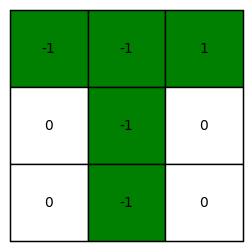

1

In [7]:
# Play the Magic Square game: Deterministic Pre-defined Mismatch
play_magic_square_game(alice_rows_mismatch, bob_columns_mismatch, 0, 1)

Round lost due to mismatch cell!


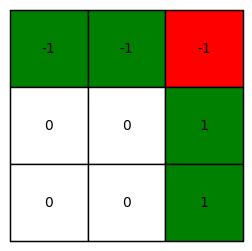

0

In [8]:
# Play the Magic Square game: Deterministic Pre-defined Mismatch
play_magic_square_game(alice_rows_mismatch, bob_columns_mismatch, 0, 2)

Round lost!


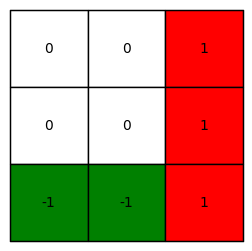

0

In [9]:
# Play the Magic Square game: Deterministic Pre-defined Product Error
play_magic_square_game(alice_rows_product, bob_columns_product, 2 , 2)

Example 1 illustrates one of the many deterministic strategies that Alice and Bob can adopt. It is not difficult to convince yourself that, no matter how they decide to fill in their entries, it is impossible for them to come up with predefined answers that always win. Any deterministic strategy is a pair of matrices, one for Alice and another for Bob. The only way that they could design a strategy that wins with certainty every round is to prepare two identical matrices satisfying the requirements for each row and for each column. That is, a single matrix for which the product of every row is +1 and the product of every column is −1. Such a matrix cannot possibly exist! It turns out that the best that they can do is to win with probability 8/9.

# Quantum Solution

#### Dependences

In [10]:
#!pip install qiskit
#!pip install 'qiskit[visualization]'

#### Imports

In [11]:
from qiskit import QuantumCircuit, assemble, Aer, ClassicalRegister, QuantumRegister, transpile, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Operator, Pauli, Statevector, partial_trace
from qiskit_aer import AerSimulator

#### Initial State: Preparing two Entangled Qubits: Bell pairs

In [12]:
def prepare_state():
    qr_Alice = QuantumRegister(2,'A')
    qr_Bob = QuantumRegister(2,'B')
    cr = ClassicalRegister(6, 'Output')
    qc = QuantumCircuit(qr_Alice, qr_Bob, cr)
    qc.h([0, 1])
    for i in range(2):
        qc.cx(i, i + 2)
    return qc

The quantum strategy for the Magic Square game consists of Alice and Bob carrying entangled qubits with them.

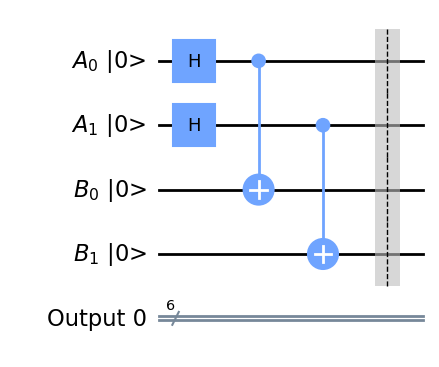

In [13]:
qc = prepare_state()
qc.barrier()
qc.draw(output="mpl", initial_state=True)

The initial, entangled state is

In [14]:
Statevector.from_instruction(qc.reverse_bits()).draw(output="latex")

<IPython.core.display.Latex object>

#### Defining measurements functions

In [15]:
def measure_zz(qc, control, target, cbit):
    """
    Same as applying CNOT(0, 1) then measuring I (x) Z
    Proof: any two qubit Pauli measurement can be
    written as U^ (Z (x) I) U or U^ (I (x) Z) U
    For the first case, we would need CNOT(1, 0),
    but the proof for (0, 1) is more convenient.
    """
    qc.cnot(control, target)
    qc.measure(target, cbit)
    qc.cnot(control, target)
    return qc

def measure_x(qbit, control, cbit):
    #qc = empty_state()
    qbit.h(control)
    qbit.measure(control, cbit)
    qbit.h(control)
    return qbit

def measure_xx(qbit, control, target, cbit):
    #qc = empty_state()
    qbit.h([control, target])
    qbit.compose(measure_zz(qbit, control, target, cbit))
    qbit.h([control, target])
    return qbit

def measure_neg_xz(qbit, control, target, cbit):
    """
    -X (x) Z = X (x) -Z = (H (x) Y) (Z (x) Z) (H (x) Y)
    """
    #qc = empty_state()
    qbit.h(control)
    qbit.y(target)
    qbit.compose(measure_zz(qbit,control, target, cbit))
    qbit.y(target)
    qbit.h(control)
    return qbit


def measure_neg_zx(qbit, control, target, cbit):
    #qc = empty_state()
    qbit.y(control)
    qbit.h(target)
    qbit.compose(measure_zz(qbit, control, target, cbit))
    qbit.h(target)
    qbit.y(control)
    return qbit


def measure_yy(qbit, control, target, cbit):
    #qc = empty_state()
    qbit.s([control, target])
    qbit.compose(measure_xx(qbit, control, target, cbit))
    qbit.sdg([control, target])
    return qbit

#### Defining Alice measurements row functions

In [16]:
def alice_first_row(qc):
  # I (x) Z
  qc.measure(1, 0)
  qc.barrier()
  # Z (x) I
  qc.measure(0, 1)
  qc.barrier()
  # Z (x) Z
  measure_zz(qc, 0, 1, 2)
  #qbit.barrier()

def alice_second_row(qc):
  # X (x) I
  measure_x(qc, 0, 0)
  qc.barrier()
  # I (x) X
  measure_x(qc, 1, 1)
  # Barrier to improve visualization
  qc.barrier()
  # X (x) X
#   qc.compose(measure_xx(qc, 0, 1, 2))
  measure_xx(qc, 0, 1, 2)

def alice_third_row(qc):
  # -X (x) Z
  measure_neg_xz(qc, 0, 1, 0)
  # Barrier to improve visualization
  qc.barrier()
  # -Z (x) X
  measure_neg_zx(qc, 0, 1, 1)
  # Barrier to improve visualization
  qc.barrier()
  # Y (x) Y
  measure_yy(qc, 0, 1, 2)

#### Examples of Alice measuring her rows

##### Alice measuring her first row

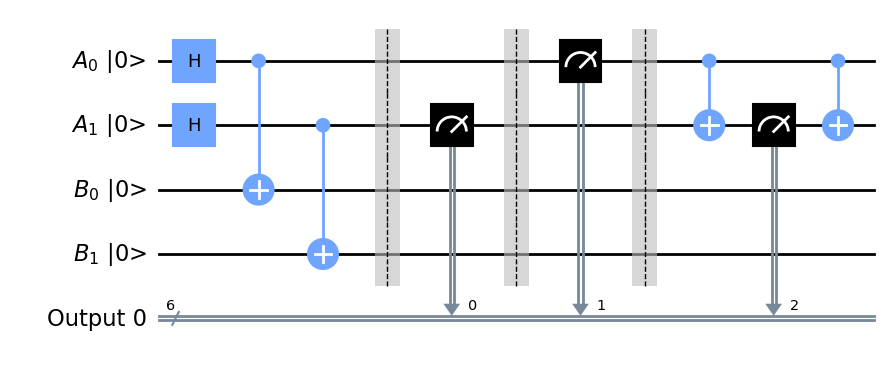

In [17]:
qc = prepare_state()
qc.barrier()
alice_first_row(qc)
qc.draw(output="mpl", initial_state=True)

##### Alice measuring her second row

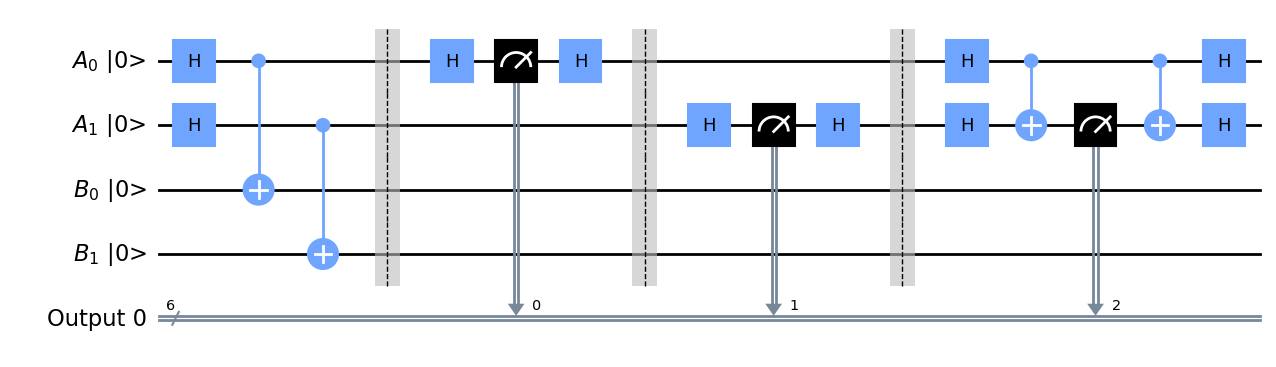

In [18]:
qc = prepare_state()
qc.barrier()
alice_second_row(qc)
qc.draw(output="mpl", initial_state=True)

##### Alice measuring her third row

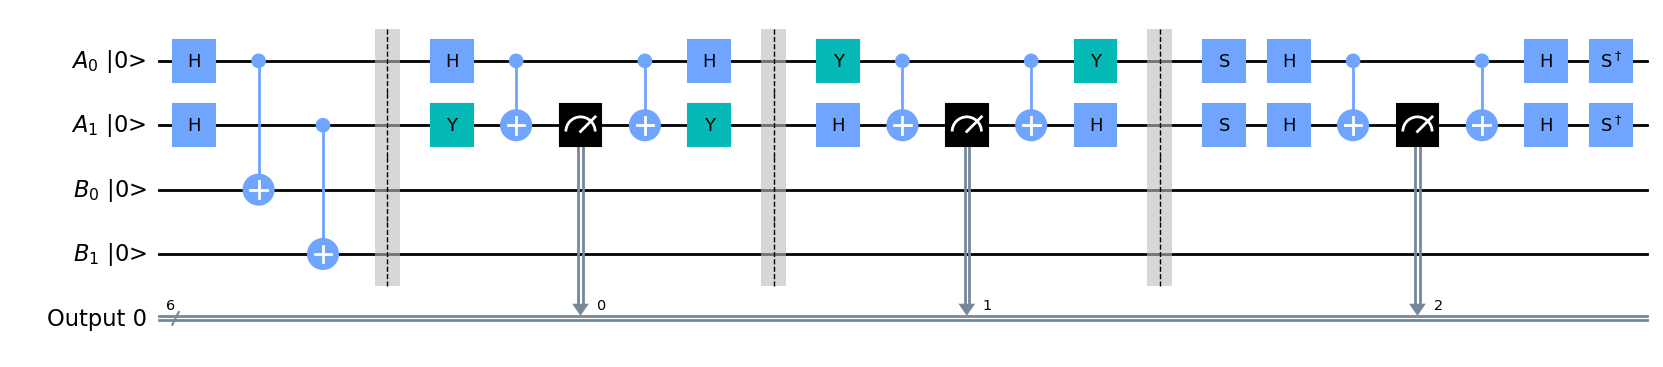

In [19]:
qc = prepare_state()
qc.barrier()
alice_third_row(qc)
qc.draw(output="mpl", initial_state=True)

#### Defining Bob measurements column functions

In [20]:
def bob_first_column(qc):
  #  I (x) Z
  qc.measure(3, 3)
  qc.barrier()
  #  X (x) I
  measure_x(qc, 2, 4)
  qc.barrier()
  # -X (x) Z
  measure_neg_xz(qc, 2, 3, 5)

def bob_second_column(qc):
  #  Z (x) I
  qc.measure(2, 3)
  qc.barrier()
  #  I (x) X
  measure_x(qc, 3, 4)
  qc.barrier()
  # -Z (x) X
  measure_neg_zx(qc, 2, 3, 5)

def bob_third_column(qc):
  # Z (x) Z
  measure_zz(qc, 2, 3, 3)
  qc.barrier()
  # X (x) X
  measure_xx(qc, 2, 3, 4)
  qc.barrier()
  # Y (x) Y
  measure_yy(qc, 2, 3, 5)

### Examples of Bob measuring his columns

#### Bob measuring his first column

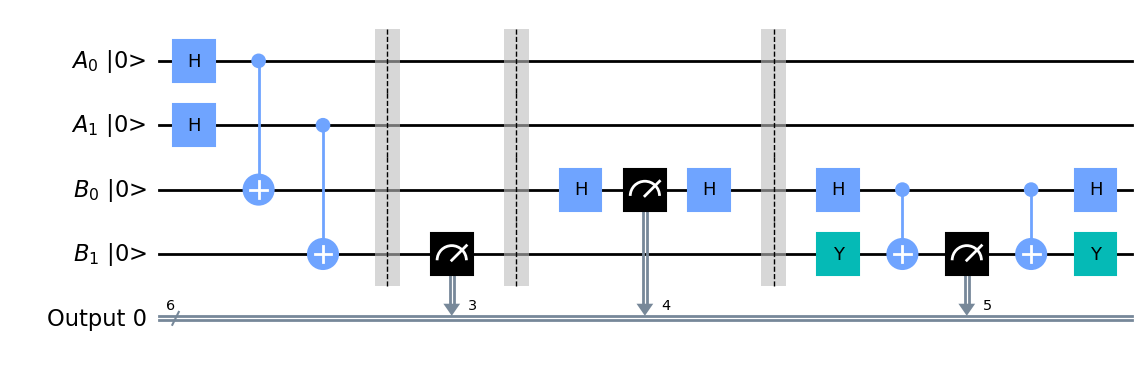

In [21]:
qc = prepare_state()
qc.barrier()
bob_first_column(qc)
qc.draw(output="mpl", initial_state=True)

#### Bob measuring his second column

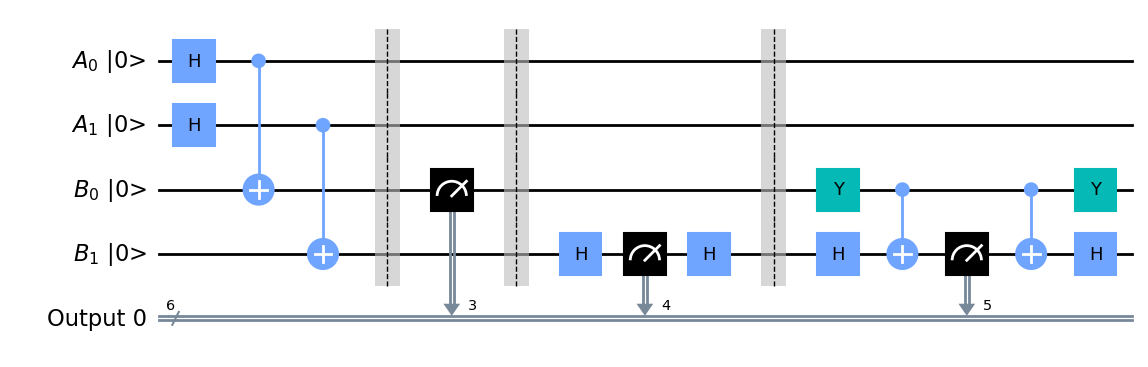

In [22]:
qc = prepare_state()
qc.barrier()
bob_second_column(qc)
qc.draw(output="mpl", initial_state=True)

#### Bob measuring his third column

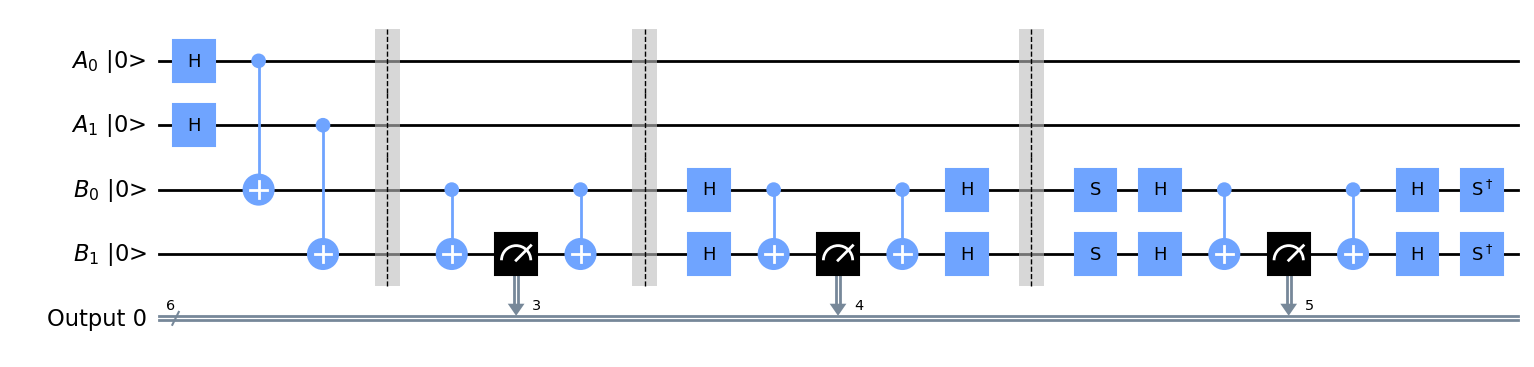

In [23]:
qc = prepare_state()
qc.barrier()
bob_third_column(qc)
qc.draw(output="mpl", initial_state=True)

### Preparing the board

In [24]:
def plot_quantum_magic_square(matrix, lost_cell=None, lost_column=None, lost_row=None):
    # Create a 3x3 grid
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    table = ax.table(cellText=matrix, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

    # Set cell text properties
    for cell in table.get_children():
        if isinstance(cell, plt.Text):
            cell.set_fontsize(20)

    # Show the plot
    plt.show()

In [25]:
quantum_magic_square_plot = np.array([ ["+I ⊗ Z", "+X ⊗ I", "-X ⊗ Z"]
                                     , ["+Z ⊗ I", "+I ⊗ X", "-Z ⊗ X"]
                                     , ["+Z ⊗ Z", "+X ⊗ X", "+Y ⊗Y"]])
alice_rows = [alice_first_row, alice_second_row, alice_third_row]
bob_columns = [bob_first_column, bob_second_column, bob_third_column]

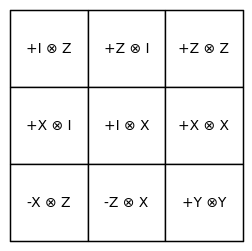

In [26]:
plot_quantum_magic_square(quantum_magic_square_plot.T)

### The Quantum Magic Square Game

In [27]:
from functools import reduce
from random import choice

def run(qc):
    backend = Aer.get_backend("statevector_simulator")
    job = backend.run(qc)
    result = list(job.result().get_counts(qc).keys())[0]
    # print(result)
    outcomes = [1 if r == '0' else -1 for r in result][::-1]
    return outcomes[:3], outcomes[3:]

def the_game(should_print=True):
    win = 0
    pick_rows = [0, 1, 2, 0, 1, 2, 0, 1, 2]
    pick_columns = [0, 1, 2, 0, 1, 2, 0, 1, 2]

    size = len(pick_rows)

    for i in range(size):
        qc = prepare_state()
        r = choice(pick_rows)
        pick_rows.remove(r)

        c = choice(pick_columns)
        pick_columns.remove(c)

        alice_rows[r](qc)
        bob_columns[c](qc)
        #display(transpile(qc, optimization_level=0).draw(output="mpl", style=style))

        result_alice, result_bob = run(qc)
        prod_alice = reduce(lambda acc, x: acc * x, result_alice)
        prod_bob = reduce(lambda acc, x: acc * x, result_bob)

        if result_alice[c] == result_bob[r] and prod_bob == -1 and prod_alice == 1:
          win += 1

        if should_print:
          print(f"Alice <- {r} -> {result_alice},\t prod = {prod_alice},\t match_cell: {result_alice[c]}")
          print(f"Bob   <- {c} -> {result_bob},\t prod = {prod_bob},\t match_cell: {result_bob[r]}")
          print()

    if should_print:
      print("Win: ", win == size)
    return win == size

In [28]:
the_game()

Alice <- 2 -> [1, -1, -1],	 prod = 1,	 match_cell: -1
Bob   <- 1 -> [1, 1, -1],	 prod = -1,	 match_cell: -1

Alice <- 1 -> [-1, -1, 1],	 prod = 1,	 match_cell: -1
Bob   <- 1 -> [-1, -1, -1],	 prod = -1,	 match_cell: -1

Alice <- 1 -> [1, -1, -1],	 prod = 1,	 match_cell: -1
Bob   <- 2 -> [-1, -1, -1],	 prod = -1,	 match_cell: -1

Alice <- 2 -> [1, 1, 1],	 prod = 1,	 match_cell: 1
Bob   <- 2 -> [1, -1, 1],	 prod = -1,	 match_cell: 1

Alice <- 1 -> [1, 1, 1],	 prod = 1,	 match_cell: 1
Bob   <- 0 -> [1, 1, -1],	 prod = -1,	 match_cell: 1

Alice <- 0 -> [-1, 1, -1],	 prod = 1,	 match_cell: -1
Bob   <- 2 -> [-1, 1, 1],	 prod = -1,	 match_cell: -1

Alice <- 0 -> [1, 1, 1],	 prod = 1,	 match_cell: 1
Bob   <- 1 -> [1, -1, 1],	 prod = -1,	 match_cell: 1

Alice <- 2 -> [-1, 1, -1],	 prod = 1,	 match_cell: -1
Bob   <- 0 -> [-1, -1, -1],	 prod = -1,	 match_cell: -1

Alice <- 0 -> [-1, 1, -1],	 prod = 1,	 match_cell: -1
Bob   <- 0 -> [-1, -1, -1],	 prod = -1,	 match_cell: -1

Win:  True


True

In [29]:
total = 0
for i in range(1000):
  if the_game(should_print=False):
    total += 1

print("Win: ", total/1000)
print("Loss: ", (1000-total)/1000)

Win:  1.0
Loss:  0.0
